In [1]:
import matplotlib.pyplot as plt

from pathlib import Path

from promg.modules.db_management import DBManagement
from tabulate import tabulate
import yaml

from promg import Configuration, DatabaseConnection, Performance, SemanticHeader, DatasetDescriptions, OcedPg, Query

import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.width', 2000)


In [2]:
case_study = 'bpic14'
load = False


In [3]:
conf_path = Path(case_study, 'config.yaml')
config = yaml.safe_load(open(conf_path))

print(f"These are the credentials that I expect to be set for the database.")
print(f"db_name: {config['db_name']}")
print(f"uri: {config['uri']}")
print(f"password: {config['password']}")
print("----------------------")
print(f"If you have other credentials, please change them at: {conf_path}")

These are the credentials that I expect to be set for the database.
db_name: neo4j
uri: bolt://localhost:7687
password: bpic2014
----------------------
If you have other credentials, please change them at: bpic14\config.yaml


In [4]:
config = Configuration.init_conf_with_config_file(conf_path)
db_connection = DatabaseConnection.set_up_connection(config=config)

In [5]:
if load:
    # Import the original modeled data
    %run./ 0_analysis_and_model.ipynb

# Check Cluster Analysis

In [11]:
# add relation between CI_SC if they shared a change
query = '''
    :auto
    MATCH (ci_sc1:CI_SC) <- [:AFFECTED_CI_SC] - (c:Change) - [:AFFECTED_CI_SC] -> (ci_sc2:CI_SC)
    WITH ci_sc1, ci_sc2, count(c) as shared_c, split(c.changeType, " ")[0] + " " + split(c.changeType, " ")[1] as change_type
    CALL (ci_sc1, ci_sc2, shared_c, change_type) {
        MERGE (ci_sc1) - [:SHARED_CHANGE {change_type: change_type, frequency: shared_c}] -> (ci_sc2)
    } IN TRANSACTIONS
    RETURN count(ci_sc1)
'''

db_connection.exec_query(query)

[{'count(ci_sc1)': 1140226}]

In [12]:
# add relation between CI_SC if they shared a change
query = '''
    :auto
    MATCH (ci_sc:CI_SC) - [sc:SHARED_CHANGE] -> (ci_sc2)
    MATCH (ci_sc) <- [:AFFECTED_CI_SC] - (c)
    WHERE NOT EXISTS ((ci_sc2)  <- [:AFFECTED_CI_SC] - (c))
    WITH sc, ci_sc, count(c) as cnt
    CALL (sc, ci_sc, cnt) {
        SET sc.not_shared = cnt
        SET sc.total = sc.frequency + sc.not_shared
        SET sc.ratio = sc.frequency*1.0 / sc.total
    } IN TRANSACTIONS
    RETURN count(sc)
'''

db_connection.exec_query(query)

[{'count(sc)': 96035}]

In [13]:
# add relation between CI_SC if they shared a change
query = '''
    :auto
    MATCH (ci_sc:CI_SC) - [sc:SHARED_CHANGE] -> (ci_sc2)
    WHERE sc.not_shared IS NULL
    CALL (sc) {
        SET sc.not_shared = 0
        SET sc.total = sc.frequency + sc.not_shared
        SET sc.ratio = sc.frequency / sc.total
    } IN TRANSACTIONS
    RETURN count(sc)
'''

db_connection.exec_query(query)

[{'count(sc)': 1074870}]

# Clusters of CI_SC
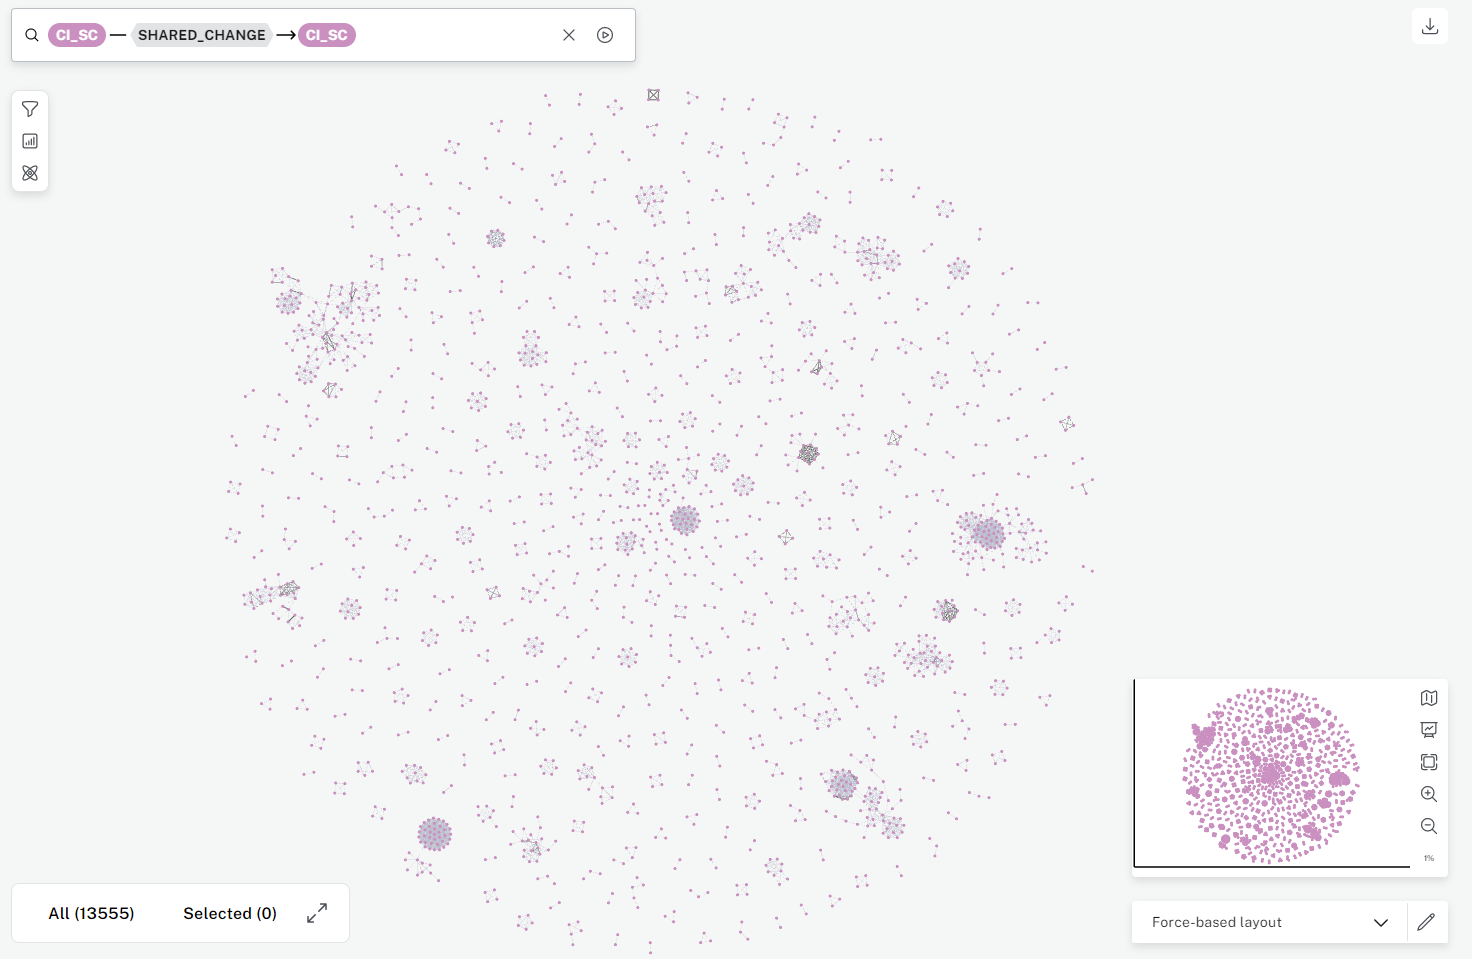

In [15]:
query = '''
:auto
MATCH (ci_sc1:CI_SC) - [sc:SHARED_CHANGE] -> (ci_sc2:CI_SC)
MATCH (ci_sc1) - [:RELATED_CI] -> (ci1:ConfigurationItem)
MATCH (ci_sc2) - [:RELATED_CI] -> (ci2:ConfigurationItem)
WITH ci1, ci2, collect(distinct sc.change_type) as change_types, sum(sc.frequency) as frequency, sum(sc.not_shared) as not_shared
CALL (ci1, ci2, change_types, frequency, not_shared) {
    MERGE (ci1) - [r:SHARED_CHANGE] -> (ci2)
    SET r.frequency = frequency
    SET r.change_type = change_types
    SET r.not_shared = not_shared
    SET r.total = frequency + not_shared
    SET r.ratio = round(r.frequency*1.0 / r.total, 4)
} IN TRANSACTIONS

'''

pd.DataFrame(db_connection.exec_query(query))

""


In [18]:
#Delete Graph
query = '''
CALL gds.graph.drop(
  'myGraph'
)
YIELD graphName;
'''

db_connection.exec_query(query)

Latest transaction was rolled back
This was your latest query: 
CALL gds.graph.drop(
  'myGraph'
)
YIELD graphName;

{neo4j_code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.graph.drop`: Caused by: org.neo4j.gds.core.loading.GraphNotFoundException: Graph with name `myGraph` does not exist on database `neo4j`. It might exist on another database.} {gql_status: 50N42} {gql_status_description: error: general processing exception - unexpected error. Unexpected error has occurred. See debug log for details.}


In [16]:
#Project Graph
query = '''
    MATCH (source:ConfigurationItem)-[r:SHARED_CHANGE]->(target:ConfigurationItem)
RETURN gds.graph.project(
  'myGraph',
  source,
  target,
  { relationshipProperties: r { .ratio } }
)
'''

db_connection.exec_query(query)

[{"gds.graph.project(\n  'myGraph',\n  source,\n  target,\n  { relationshipProperties: r { .ratio } }\n)": {'relationshipCount': 1135446,
   'graphName': 'myGraph',
   'query': "\n    MATCH (source:ConfigurationItem)-[r:SHARED_CHANGE]->(target:ConfigurationItem)\nRETURN gds.graph.project(\n  'myGraph',\n  source,\n  target,\n  { relationshipProperties: r { .ratio } }\n)\n",
   'projectMillis': 1026,
   'configuration': {'readConcurrency': 4,
    'undirectedRelationshipTypes': [],
    'jobId': 'ba89ff64-c80b-4aea-968c-6666d6bf6d18',
    'logProgress': True,
    'query': "\n    MATCH (source:ConfigurationItem)-[r:SHARED_CHANGE]->(target:ConfigurationItem)\nRETURN gds.graph.project(\n  'myGraph',\n  source,\n  target,\n  { relationshipProperties: r { .ratio } }\n)\n",
    'inverseIndexedRelationshipTypes': []},
   'nodeCount': 7163}}]

In [17]:
# Estimate Memory costs
query = '''
    CALL gds.wcc.write.estimate('myGraph', { writeProperty: 'component' })
    YIELD nodeCount, relationshipCount, bytesMin, bytesMax, requiredMemory
'''

db_connection.exec_query(query)

[{'nodeCount': 7163,
  'relationshipCount': 1135446,
  'bytesMin': 57400,
  'bytesMax': 57400,
  'requiredMemory': '56 KiB'}]

In [55]:
#Determine number of components
query = '''
    CALL gds.wcc.stats('myGraph',
    {
  relationshipWeightProperty: 'ratio',
  threshold: $threshold
})
    YIELD componentCount, componentDistribution
'''
component_results = {}
component_distributions = {}
for i in np.arange(0, 1.01, 0.01):

    threshold = float(i)
    query_obj = Query(
        query_str=query,
        parameters={"threshold": threshold}
    )
    result = db_connection.exec_query(query_obj)
    component_results[round(threshold, 2)] = result[0]['componentCount']
    component_distributions[round(threshold, 2)] = result[0]['componentDistribution']


Motivate threshold
Analyze groups with

<Axes: >

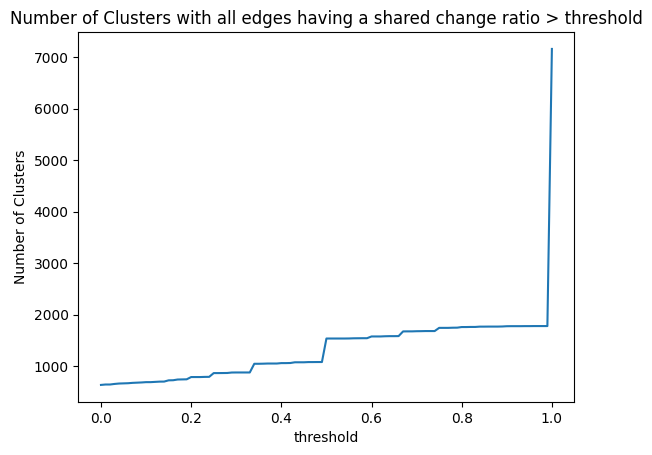

In [56]:
# print(results)
ax = sns.lineplot(data=component_results)

plt.title('Number of Clusters with all edges having a shared change ratio > threshold', )
ax.set(xlabel='threshold', ylabel='Number of Clusters')
p

<Axes: >

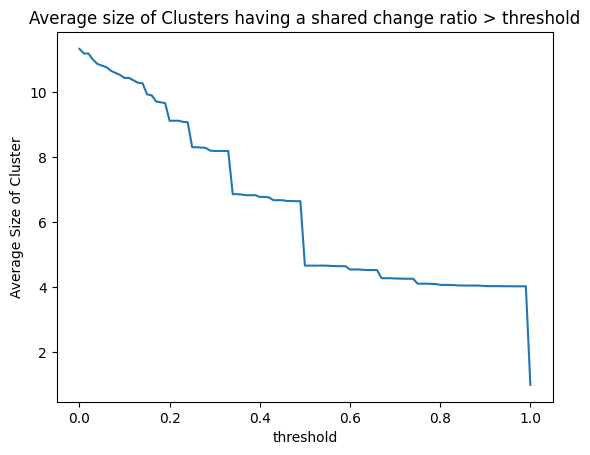

In [57]:
# print(results)
ax = sns.lineplot(data={key: value['mean'] for key, value in component_distributions.items()})

plt.title('Average size of Clusters having a shared change ratio > threshold', )
ax.set(xlabel='threshold', ylabel='Average Size of Cluster')
p

<Axes: >

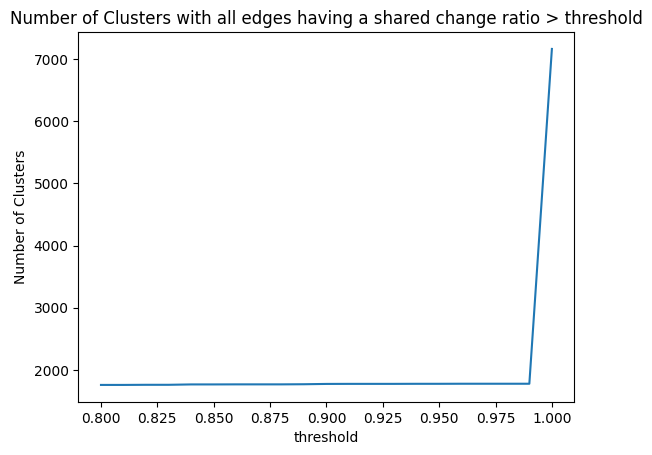

In [58]:
# Zoomed in version
# print(results)
ax = sns.lineplot(data={key: value for key, value in component_results.items() if key >= 0.8})

plt.title('Number of Clusters with all edges having a shared change ratio > threshold', )
ax.set(xlabel='threshold', ylabel='Number of Clusters')
p

<Axes: >

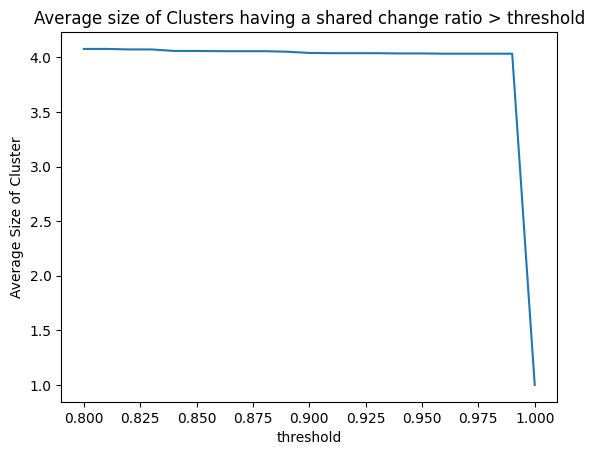

In [59]:
# print(results)
ax = sns.lineplot(data={key: value['mean'] for key, value in component_distributions.items() if key>=0.8})

plt.title('Average size of Clusters having a shared change ratio > threshold', )
ax.set(xlabel='threshold', ylabel='Average Size of Cluster')
p

In [60]:
threshold = 0.975
query_obj = Query(
        query_str=query,
        parameters={"threshold": threshold}
    )
db_connection.exec_query(query_obj)

[{'componentCount': 1776,
  'componentDistribution': {'min': 1,
   'p5': 1,
   'max': 1110,
   'p999': 399,
   'p99': 33,
   'p1': 1,
   'p10': 1,
   'p90': 5,
   'p50': 1,
   'p25': 1,
   'p75': 2,
   'p95': 8,
   'mean': 4.0332207207207205}}]

In [61]:
#write component Id to ConfigurationItems
query  = '''
    CALL gds.wcc.write('myGraph', {
      writeProperty: 'clusterId',
      relationshipWeightProperty: 'ratio',
      threshold: $threshold
  })
    YIELD nodePropertiesWritten, componentCount;
'''

query_obj = Query(
        query_str=query,
        parameters={"threshold": threshold}
    )
db_connection.exec_query(query_obj)

[{'nodePropertiesWritten': 7163, 'componentCount': 1776}]

In [62]:
query = '''
    MATCH (ci:ConfigurationItem) - [r:SHARED_CHANGE] -> (ci2:ConfigurationItem)
    WHERE ci.clusterId = ci2.clusterId
    WITH ci.clusterId as clusterId, avg(r.ratio) as avg
    MERGE (ci_new:ConfigurationItemCluster {clusterId: clusterId, ratio: avg})
    WITH ci_new
    MATCH (ci:ConfigurationItem {clusterId: ci_new.clusterId})
    MERGE (ci_new) - [:CONTAINS] -> (ci)
'''

pd.DataFrame(db_connection.exec_query(query))

""


In [64]:

query = '''
    MATCH (ci_c:ConfigurationItemCluster) - [:CONTAINS] -> (ci2:ConfigurationItem)
    WITH ci_c, count(ci2) as cnt
    SET ci_c.number_of_cis = cnt
'''

db_connection.exec_query(query)

[]

In [65]:
query = '''
    MATCH (ci_c:ConfigurationItemCluster) - [:CONTAINS] -> (ci2:ConfigurationItem) <- [:RELATED_CI] - (:CI_SC) - [:RELATED_SC] -> (sc:ServiceComponent)
    MERGE (ci_c) - [:RELATED_SC] -> (sc)
    WITH ci_c, count(distinct ci2) as cnt, collect(distinct COALESCE(ci2.ciType, "NA")) as ciType, collect(distinct COALESCE(ci2.ciSubtype, "NA")) as ciSubType
    SET ci_c.number_of_cis = cnt
    SET ci_c.ciType = ciType
    SET ci_c.ciSubtype = ciSubType
'''

result = db_connection.exec_query(query)

In [66]:
query = '''
    MATCH (ci_c:ConfigurationItemCluster) - [:CONTAINS] -> (ci2:ConfigurationItem) <- [:RELATED_CI] - (:CI_SC) <- [:AFFECTED_CI_SC] - (c:Change)
    MERGE (ci_c) <- [:CHANGED_CI] - (c)
    WITH ci_c, count(distinct c) as num_changes
    SET ci_c.num_changes = num_changes
'''

result = db_connection.exec_query(query)

In [78]:
query = '''
    MATCH (ci_c:ConfigurationItemCluster) - [:CHANGED_CI] - (c:Change)
    WHERE ci_c.num_changes > 1
    RETURN distinct ci_c.clusterId as clusterId, ci_c.number_of_cis as num_cis, ci_c.ciType as ci_type, ci_c.ciSubtype  as ci_subtype, ci_c.num_changes as num_changes, ci_c.ratio as `%_shared_changes` ORDER BY ci_c.ratio DESC
'''

pd.DataFrame(db_connection.exec_query(query))

,clusterId,num_cis,ci_type,ci_subtype,num_changes,%_shared_changes
0,496,2,[database],[RAC Service],3,1.000000
1,1799,2,[subapplication],[Server Based Application],2,1.000000
2,1803,2,[software],[System Software],2,1.000000
3,2405,2,[computer],[Appliance],2,1.000000
4,1747,2,[application],[Server Based Application],2,1.000000
...,...,...,...,...,...,...
513,2231,8,[computer],[Linux Server],21,0.377504
514,923,3,[database],[RAC Service],44,0.363100
515,803,9,"[application, computer]","[Standard Application, Linux Server, Unix Server]",38,0.335019
516,912,9,"[application, subapplication, database]","[Server Based Application, RAC Service]",55,0.311873


Explore Component ID = 4349


In [93]:
query = '''
    MATCH (ci:ConfigurationItem)
    RETURN ci.ciType as type, ci.ciSubtype as subtype, count(ci) as total_ci
'''

total_result = pd.DataFrame(db_connection.exec_query(query))

In [104]:
query = '''
    MATCH (ci_c:ConfigurationItemCluster) - [:CONTAINS] -> (ci:ConfigurationItem)
    RETURN ci.ciType as type, ci.ciSubtype as subtype, count(ci) as num_ci_in_cluster, count(distinct ci_c) as num_clusters, avg(ci_c.ratio) as avg_ratio_of_clusters
'''

component_result = pd.DataFrame(db_connection.exec_query(query))

In [105]:
combined_result = total_result.merge(component_result, on=['type', 'subtype'], how='left')
combined_result = combined_result.fillna(0)
combined_result['% cis in cluster'] = combined_result['num_ci_in_cluster']/combined_result['total_ci']
combined_result['avg ci per cluster'] = combined_result['num_ci_in_cluster']/combined_result['num_clusters']
combined_result = combined_result[['clusterId', 'type', 'subtype', 'total_ci', 'num_ci_in_cluster', '% cis in cluster', 'avg_ratio_of_clusters', 'avg ci per cluster' ]]
combined_result

,clusterId,type,subtype,total_ci,num_ci_in_cluster,% cis in cluster,avg_ratio_of_clusters,avg ci per cluster
0,11.0,computer,Linux Server,1056,2.0,0.001894,0.575546,2.0
1,408.0,computer,Linux Server,1056,19.0,0.017992,0.418047,19.0
2,532.0,computer,Linux Server,1056,4.0,0.003788,0.475000,4.0
3,783.0,computer,Linux Server,1056,2.0,0.001894,0.708325,2.0
4,422.0,computer,Linux Server,1056,9.0,0.008523,0.498718,9.0
...,...,...,...,...,...,...,...,...
1159,0.0,#N/B,#N/B,1,0.0,0.000000,0.000000,NaN
1160,0.0,software,Sealbag Software,1,0.0,0.000000,0.000000,NaN
1161,0.0,computer,Tablet,1,0.0,0.000000,0.000000,NaN
1162,0.0,subapplication,Exchange,1,0.0,0.000000,0.000000,NaN


In [102]:
combined_result[(combined_result['% cis in cluster'] >= .8) & (combined_result['avg_ratio_of_clusters'] >= .8)].sort_values('total_ci', ascending=False)


,type,subtype,total_ci,num_ci_in_cluster,% cis in cluster,avg_ratio_of_clusters,avg ci per cluster
69,computer,VDI,1038,1002.0,0.965318,0.993702,501.000000
25,software,System Software,574,470.0,0.818815,0.807887,5.595238
29,computer,ESX Cluster,85,78.0,0.917647,0.897086,5.571429
60,computer,HSM Server,76,75.0,0.986842,0.883024,37.500000
52,computer,ESX Server,51,48.0,0.941176,0.907319,8.000000
6,software,Automation Software,27,23.0,0.851852,0.821152,3.833333
61,computer,Windows Server in extern beheer,25,24.0,0.960000,0.876530,6.000000
38,storage,Tape Library,23,21.0,0.913043,0.812764,7.000000
68,application,VMWare,22,22.0,1.000000,0.973142,11.000000
42,computer,Vio,8,7.0,0.875000,0.875852,1.750000


Switches participate often together
Managed consistently in the same way
64% not managed togetger for Linux Server
Distinguish Linux Server managed together and those not together.
    What's the CI_SC lifecycle,
    How many changes/incidents/interactions within a cluster and those not
    Managed together, if there is a change in a group of servers managed together, where does the change come from. 1 incident causes many changes (always the same server)??
     As a result done for many.


Performance spectrum.

In [153]:
query = '''
MATCH (cic:ConfigurationItemCluster) - [:CONTAINS] -> (ci:ConfigurationItem)
CALL (cic) {
  MATCH (cic:ConfigurationItemCluster) - [:CONTAINS] -> (all_ci:ConfigurationItem)
  RETURN count(all_ci) as total_ci
}
MATCH (ci) <- [:RELATED_CI] - (ci_sc:CI_SC)
MATCH (ci_sc) <- [:CORR] - (e:Event) - [:CORR] -> (n) - [:IS_OF_TYPE] -> (ot:ObjectType)
WHERE ot.objectType IN ['Change', 'Incident', 'Interaction']
RETURN cic.clusterId as cluster, total_ci, ot.objectType as objectType, count(distinct ci.sysId) as involved_ci, count(e) as events ORDER BY cluster, objectType
'''

result = pd.DataFrame(db_connection.exec_query(query))
table = pd.pivot_table(
    result,
    values=['events', 'involved_ci'],
    index=['cluster', 'total_ci'],
    columns='objectType'
)
table.fillna(0, inplace=True)
table.columns = table.columns.to_flat_index().map(lambda x: ': '.join(reversed(x)))
table.reset_index(inplace=True)
table = table[['cluster', 'total_ci', 'Change: involved_ci', 'Change: events', 'Incident: involved_ci', 'Incident: events','Interaction: involved_ci', 'Interaction: events']]
table

,cluster,total_ci,Change: involved_ci,Change: events,Incident: involved_ci,Incident: events,Interaction: involved_ci,Interaction: events
0,1,92,92.0,574.0,1.0,24.0,1.0,6.0
1,3,21,21.0,80.0,1.0,2700.0,1.0,824.0
2,4,2,2.0,108.0,1.0,20445.0,1.0,13768.0
3,5,27,27.0,170.0,3.0,233.0,2.0,48.0
4,8,4,4.0,48.0,2.0,2330.0,2.0,928.0
...,...,...,...,...,...,...,...,...
770,7150,3,3.0,6.0,0.0,0.0,0.0,0.0
771,7153,2,2.0,4.0,0.0,0.0,0.0,0.0
772,7155,2,2.0,4.0,0.0,0.0,0.0,0.0
773,7157,2,2.0,4.0,0.0,0.0,0.0,0.0


In [187]:
for num_interaction in range(0, 3):
    for num_incident in range(0, 3):
        if num_interaction == 2 or num_incident == 2:
            if num_incident == 2 and num_interaction == 2:
                print(f">1 interactions and >1 incidents")
                filtered_df = table[(table['Incident: involved_ci'] > 1) & (table['Interaction: involved_ci'] > 1)]
            else:
                continue
        else:
            print(f"{num_interaction} interaction{'s' if num_interaction != 1 else ''} and {num_incident} incident{'s' if num_incident != 1 else ''}")
            filtered_df = table[(table['Incident: involved_ci'] == num_incident) & (table['Interaction: involved_ci'] == num_interaction)]

        print(f"Number of clusters: {len(filtered_df)}")
        print(f"Changes Characteristics")
        print(f"    Range: {filtered_df['Change: involved_ci'].min()} - {filtered_df['Change: involved_ci'].max()}")
        print(f"    Average: {round(filtered_df['Change: involved_ci'].mean(), 2)} (+- {round(filtered_df['Change: involved_ci'].std(), 2)})")
        print(f"------------------------------------------")



0 interactions and 0 incidents
Number of clusters: 657
Changes Characteristics
    Range: 1.0 - 109.0
    Average: 4.25 (+- 6.89)
------------------------------------------
0 interactions and 1 incident
Number of clusters: 7
Changes Characteristics
    Range: 2.0 - 6.0
    Average: 2.86 (+- 1.46)
------------------------------------------
1 interaction and 0 incidents
Number of clusters: 12
Changes Characteristics
    Range: 0.0 - 19.0
    Average: 4.33 (+- 5.07)
------------------------------------------
1 interaction and 1 incident
Number of clusters: 75
Changes Characteristics
    Range: 0.0 - 92.0
    Average: 6.57 (+- 12.01)
------------------------------------------
>1 interactions and >1 incidents
Number of clusters: 22
Changes Characteristics
    Range: 0.0 - 382.0
    Average: 67.27 (+- 97.2)
------------------------------------------


In [188]:
filtered_df = table[(table['Incident: involved_ci'] == 0) & (table['Interaction: involved_ci'] == 0)]
filtered_df

,cluster,total_ci,Change: involved_ci,Change: events,Incident: involved_ci,Incident: events,Interaction: involved_ci,Interaction: events
5,11,56,56.0,716.0,0.0,0.0,0.0,0.0
6,17,49,49.0,226.0,0.0,0.0,0.0,0.0
7,19,2,2.0,44.0,0.0,0.0,0.0,0.0
8,39,6,6.0,20.0,0.0,0.0,0.0,0.0
9,44,2,2.0,34.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
770,7150,3,3.0,6.0,0.0,0.0,0.0,0.0
771,7153,2,2.0,4.0,0.0,0.0,0.0,0.0
772,7155,2,2.0,4.0,0.0,0.0,0.0,0.0
773,7157,2,2.0,4.0,0.0,0.0,0.0,0.0


Filter on the types!!

GO BACK TO EVENTS
1) Why is this happening?
2) How and what's the impact?
1) Are there changes that affect a lot of CIs, could lead to a lot of interactions.

Take one of the perspective, what is the process part?
Improve process
Whenever change with a lot of interaction.
Changes that are hyperconnected.

- Are changes of specific types always happening at specific points in the time?
- What is the correlation between the implementation of a change and the number of closed interactions and incidents after the change?
- What is the relation between the teams that participate in the interaction, incident, change management.

Are there types of CI_SC, that result in specific patterns.
    How does the process look like?

Variant Analysis
--> Is there a team involved.
--> Number of changes + how big are the changes --> big + small change.


DOTTED CHART for Components (5).

Add number of ci_sc affected to Changes.

CAUSE + AFFECTED.


Set Variants.
Interaction OPEN to CLOSE
CAUSAL Relation.

In [32]:
query = '''
    MATCH (ci:ConfigurationItem) <- [:RELATED_CI] - (:CI_SC) <- [:CORR] - (e:Event)
    RETURN ci.ciType as type, ci.ciSubtype as subtype, count(e) as number_of_events
'''

pd.DataFrame(db_connection.exec_query(query))

,type,subtype,number_of_events
0,computer,Linux Server,11393
1,application,Server Based Application,322893
2,networkcomponents,Switch,7100
3,database,Instance,4063
4,database,RAC Service,4768
...,...,...,...
88,computer,NonStop Harddisk,26
89,computer,NonStop Storage,14
90,#N/B,#N/B,32
91,software,Sealbag Software,6


In [33]:
query = '''
    MERGE (big_c:ChangeGroup {sysId: $index})
    WITH big_c
    UNWIND $changes as change
    MATCH (c:Change {sysId: change})
    MERGE (big_c) - [:CONTAINS] -> (c)
    '''

for index, changes in enumerate(connected_change):
    query_obj = Query(
        query_str=query,
        parameters={
            'changes': list(changes),
            'index': index
        }
    )
    db_connection.exec_query(query_obj)

NameError: name 'connected_change' is not defined

In [ ]:
query = '''
MATCH (big_c:ChangeGroup) - [:CONTAINS] -> (c:Change)
WITH big_c, count(c) as number_of_changes
SET big_c.numberOfChanges = number_of_changes
'''

db_connection.exec_query(query)

In [ ]:
query = '''
MATCH (big_c:ChangeGroup) - [:CONTAINS] -> (c:Change) - [:AFFECTED_CI_SC] -> (ci_sc:CI_SC)
WITH big_c, ci_sc, count(c) as number_of_changes
MERGE (big_c) - [r:AFFECTED_CI_SC] -> (ci_sc)
SET r.numberOfChanges = number_of_changes
SET r.ratio = round(r.numberOfChanges*1.0/big_c.numberOfChanges, 3)
'''

db_connection.exec_query(query)